# What

This notebook will be where the work for #165 will take place.

As per the issues there are three steps, getting embedding dataset, creating the vector database and then building the RAg on top.

## Modules

In [2]:
# Third Party
import pandas as pd

from dotenv import load_dotenv
load_dotenv('../../.env')

import openai

from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import lancedb
import pyarrow as pa

import voyageai

# built in
import os

# Getting safety issue embeddings ready


In [64]:
def read_embedding(file_name):

    embedding_folder = 'embeddings'

    return pd.read_pickle(os.path.join(embedding_folder, file_name))

In [65]:
safety_issue_embeddings = read_embedding('voyageai_si_embeddings.pkl')
safety_issue_embeddings.rename(columns={'si_embedding': 'vector'}, inplace=True)
safety_issue_embeddings

,report_id,si,vector
0,2010_001,Airways also required controllers to pass pire...,"[0.0235306266695261, 0.026190070435404778, -0...."
1,2010_001,Airways required all pireps to be passed to Me...,"[0.019533971324563026, -0.004194759298115969, ..."
2,2010_001,Limitations in the operator's dispatch system ...,"[0.0211117435246706, 0.0030384294223040342, -0..."
3,2010_001,The first air traffic controller did not hear ...,"[-0.0047742570750415325, 0.019065624102950096,..."
4,2010_001,The report of loose objects on one flight deck...,"[0.051376212388277054, 0.023183481767773628, -..."
...,...,...,...
555,2020_103,There was no evidence that the rail industry h...,"[0.035960517823696136, 0.000566903268918395, -..."
556,2020_104,Implementation of an administrative control me...,"[0.012205546721816063, 0.027715783566236496, -..."
557,2020_104,The use of an administrative control measure w...,"[0.035122018307447433, 0.0015466450713574886, ..."
558,2020_201,The deckhand keeping watch on board the Leila ...,"[0.007662773597985506, 0.006944420747458935, 0..."


## Checking safety issues distrubitions

I have done a rerun of the safety issues and included all since 2000. This means I have alot more safety issues. I need to do a recheck to see if the safety issue extraction is good enough. I think it is quite variable as there seems to be 660ish where the last run through only had 560. More so I didn't think I was doing a run through where it would redo the safety issues.

<Axes: >

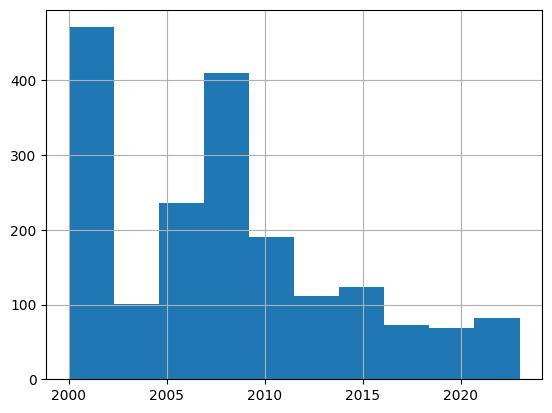

In [ ]:
si_df_test = pd.read_csv('../../output/safety_issues.csv')

si_df_test['year'] = si_df_test['report_id'].apply(lambda x: int(x[0:4]))

si_df_test['year'].hist()


In [ ]:
si_df_test.query('year >= 2010')['year']

2       2019
3       2013
4       2013
5       2013
6       2013
        ... 
1814    2011
1818    2017
1826    2017
1845    2020
1846    2020
Name: year, Length: 649, dtype: int64

<Axes: >

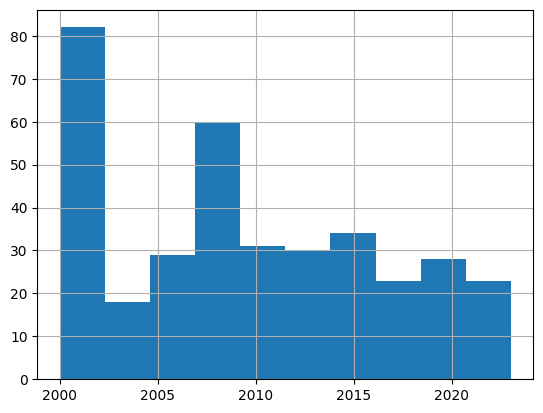

In [ ]:
si_df_test.drop_duplicates(subset=['report_id'])['year'].hist()

# Creating vector database

In [35]:
uri = 'databases/safety_issue_rag-lancedb'
db = lancedb.connect(uri)

In [80]:
vo = voyageai.Client()

def embed_query(text):

    return vo.embed(text, model="voyage-large-2-instruct", input_type="query", truncation=False).embeddings[0]

## basic safety issues

I am noticing a problem of it not really getting the safety issues which are relevant. One big thing is that it isnt even finding the exact same safety issue! This is a bit of a problem.

In [90]:
si_table = db.create_table('safety_issue_embeddings', data = safety_issue_embeddings, mode='overwrite')

si_table

LanceTable(connection=LanceDBConnection(/home/james/code/TAIC-report-summary/notebooks/vector database exploration/databases/safety_issue_rag-lancedb), name="safety_issue_embeddings")

### Simple vector search

In [105]:
query = "Close proximity events at unattended aerodromes"
search_results = si_table.search(embed_query(query)) \
    .metric("cosine") \
    .limit(100) \
    .to_pandas()

search_results

,report_id,si,vector,_distance
0,2019_006,"Aerodrome managers, in particular those at una...","[-0.003994223, 0.0041250335, 0.0036287047, 0.0...",0.271422
1,2019_006,The defence of 'see and avoid' is not foolproo...,"[0.036121774, 0.02155234, 0.025125505, -0.0253...",0.295459
2,2010_005,Local aerodrome user groups benefit their part...,"[0.0359204, -0.00898846, -0.006953316, -0.0257...",0.308064
3,2020_003,The need for comprehensive training and experi...,"[-0.00816307, 0.029414471, -0.022614159, 0.001...",0.314813
4,2010_006,The practice of using the runway for perimeter...,"[0.03981119, 0.022379799, -0.024052132, 0.0160...",0.345452
...,...,...,...,...
95,2013_006,variances in lighting seen at Auckland Airport...,"[0.0037173585, 0.016305361, 0.020727709, 0.042...",0.422202
96,2013_009,The absence of the 1225 special weather report...,"[0.010430236, -0.00013405584, -0.021723745, 0....",0.422708
97,2019_101,"Non-technical skills, particularly in communic...","[-0.008688896, 0.026003174, -0.042322405, 0.04...",0.422746
98,2019_107,The newly certified Melling train driver's rel...,"[0.06352319, -0.0040605636, -0.037888713, 0.06...",0.422816


### Hybrid search

In [106]:

si_table.create_fts_index("si", replace=True)

# hybrid search with default re-ranker
results = si_table.search((embed_query(query), query), query_type="hybrid").to_pandas()
results

,report_id,si,vector,_relevance_score
0,2019_006,"Aerodrome managers, in particular those at una...","[-0.003994223, 0.0041250335, 0.0036287047, 0.0...",0.923737
1,2019_006,The defence of 'see and avoid' is not foolproo...,"[0.036121774, 0.02155234, 0.025125505, -0.0253...",0.509126
2,2010_005,Local aerodrome user groups benefit their part...,"[0.0359204, -0.00898846, -0.006953316, -0.0257...",0.404466
3,2020_003,The need for comprehensive training and experi...,"[-0.00816307, 0.029414471, -0.022614159, 0.001...",0.350035
4,2016_203,The cadet was allowed to work at height close ...,"[0.019486494, 0.010236033, 0.001041602, 0.0485...",0.204231
5,2010_005,Civil Aviation Rule 91.223 can be interpreted ...,"[-0.0029669548, 0.010661324, 0.019351719, 0.01...",0.178750
6,2020_003,The importance of pilot training to include em...,"[0.024444388, -0.010275807, -0.021477563, -0.0...",0.111060
7,2010_006,The practice of using the runway for perimeter...,"[0.03981119, 0.022379799, -0.024052132, 0.0160...",0.102929
8,2015_009,Changes in the size and shape of the Hamilton ...,"[0.041342277, -0.0031766926, -0.017588293, -0....",0.079958
9,2010_005,"The aviation community, including the regulato...","[0.02528762, 0.021870557, 0.0030511986, 0.0138...",0.068738


# Adding RAG ontop of the vector database